<a href="https://colab.research.google.com/github/masfudindc/Machine_Learning/blob/main/Week10_Praktikum1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RNN untuk Analisis Sentimen**



---



# **Import Library**

Impor matplotlib dan buat fungsi pembantu untuk memplot grafik

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

# **Setup Input Pipeline**

Dataset ulasan film IMDB adalah kumpulan data klasifikasi biner—semua ulasan memiliki sentimen positif atau negatif.

Download dataset menggunakan TFDS (https://www.tensorflow.org/datasets). Lihat loading text tutorial (https://www.tensorflow.org/tutorials/load_data/text) jika ingin me load data secara manual

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Awalnya ini mengembalikan dataset (teks, pasangan label):

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'I nominate this and BABYLON 5 as the best television sci-fi series made. Both stand out in my mind because unlike early STAR TREK series, there is a consistent evolution of plots and characters. If you look at the original STAR TREK and STAR TREK:TNG, they were fine shows, but there was no overall theme or plot that connected all the episodes. In many ways, you could usually watch the shows totally out of sequence with no difficulty understanding what is occurring. This was less the case with DEEP SPACE 9 (with its giant battles that took up all of the final season) and the other TREK shows, as there was more of a larger story that unified them. This coherence seems to have developed as a concept with BABYLON 5 and saw this to an even greater extent with SG-1. The bottom line is that in many ways this series was like watching a family or a long novel slowly take form. Sure, there were a few "throwaway" episodes that were not connected to the rest, but these were very few and

# **Buat Teks Encoder**

Teks mentah yang dimuat oleh tfds perlu diproses sebelum dapat digunakan dalam model. Cara termudah memproses teks untuk pelatihan adalah menggunakan lapisan TextVectorization. Lapisan ini memiliki banyak kemampuan, namun pada tutorial ini menggunakan perilaku default. Buat lapisan tersebut, dan teruskan teks kumpulan data ke metode .adapt lapisan:

In [6]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi:

In [7]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap):

In [8]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 10,   1,  11, ...,   0,   0,   0],
       [  1,   1,   1, ...,   0,   0,   0],
       [ 11,   7, 210, ...,   0,   0,   0]])

Dengan pengaturan default, prosesnya tidak dapat dibalik sepenuhnya. Ada dua alasan utama untuk itu:

- Nilai default untuk argumen standarisasi preprocessing.TextVectorization adalah "lower_and_strip_punctuation".

- Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui.

In [9]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'I nominate this and BABYLON 5 as the best television sci-fi series made. Both stand out in my mind because unlike early STAR TREK series, there is a consistent evolution of plots and characters. If you look at the original STAR TREK and STAR TREK:TNG, they were fine shows, but there was no overall theme or plot that connected all the episodes. In many ways, you could usually watch the shows totally out of sequence with no difficulty understanding what is occurring. This was less the case with DEEP SPACE 9 (with its giant battles that took up all of the final season) and the other TREK shows, as there was more of a larger story that unified them. This coherence seems to have developed as a concept with BABYLON 5 and saw this to an even greater extent with SG-1. The bottom line is that in many ways this series was like watching a family or a long novel slowly take form. Sure, there were a few "throwaway" episodes that were not connected to the rest, but these were very few a

# **Buat Model**

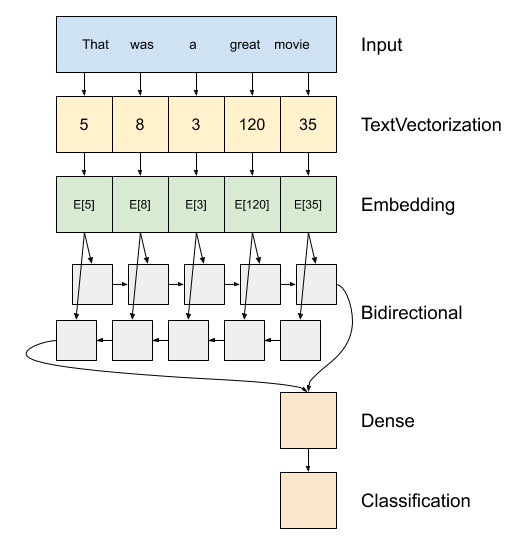

diagram model dapat dilihat pada gambar diatas

1. Model ini dapat dibuat sebagai tf.keras.Sequential.

2. Lapisan pertama adalah encoder, yang mengubah teks menjadi urutan indeks token.

3. Setelah encoder adalah lapisan penyematan (embedding layer). Lapisan penyematan menyimpan satu vektor per kata. Saat dipanggil, ini mengubah rangkaian indeks kata menjadi rangkaian vektor. Vektor-vektor ini dapat dilatih. Setelah pelatihan (dengan data yang cukup), kata-kata dengan arti yang mirip sering kali memiliki vektor yang serupa. Pencarian indeks ini jauh lebih efisien daripada operasi setara dengan meneruskan vektor yang disandikan one-hot melalui lapisan tf.keras.layers.Dense.

4. Jaringan saraf berulang (RNN) memproses masukan urutan dengan melakukan iterasi melalui elemen. RNN meneruskan keluaran dari satu langkah waktu ke masukannya pada langkah waktu berikutnya.
Pembungkus tf.keras.layers.Bidirection juga dapat digunakan dengan lapisan RNN. Ini menyebarkan masukan maju dan mundur melalui lapisan RNN dan kemudian menggabungkan keluaran akhir.
- Keuntungan utama RNN dua arah adalah sinyal dari awal masukan tidak perlu diproses sepanjang waktu untuk memengaruhi keluaran.
- Kerugian utama dari RNN dua arah adalah Anda tidak dapat melakukan streaming prediksi secara efisien saat kata-kata ditambahkan di akhir.


5. Setelah RNN mengonversi urutan menjadi satu vektor, kedua lapisan tersebut.Dense melakukan beberapa pemrosesan akhir, dan mengonversi representasi vektor ini menjadi logit tunggal sebagai keluaran klasifikasi.

Kode nya adalah sebagai berikut :

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Harap dicatat bahwa model sekuensial Keras digunakan di sini karena semua lapisan dalam model hanya memiliki masukan tunggal dan menghasilkan keluaran tunggal. Jika Anda ingin menggunakan lapisan RNN stateful, Anda mungkin ingin membangun model Anda dengan API fungsional Keras atau subkelas model sehingga Anda dapat mengambil dan menggunakan kembali status lapisan RNN. Untuk detailnya bisa dilihat pada Keras RNN guide (https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse).

Lapisan penyematan menggunakan masking (https://www.tensorflow.org/guide/keras/masking_and_padding) untuk menangani panjang urutan yang bervariasi. Semua lapisan setelah penyematan dukungan penyematan

In [11]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


Untuk memastikan bahwa ini berfungsi seperti yang diharapkan, evaluasi sebuah kalimat dua kali. Pertama, satu kalimat sehingga tidak ada bantalan (padding) untuk disamarkan:

In [12]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 7s 7s/step
[0.00929464]


Sekarang, evaluasi lagi dalam batch dengan kalimat yang lebih panjang. Hasilnya harus sama:

In [13]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 62ms/step
[0.00929464]


compile model Keras untuk mengonfigurasi proses pelatihan:

In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

# **Train Model**

In [15]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 65s 134ms/step - loss: 0.6381 - accuracy: 0.5852 - val_loss: 0.4895 - val_accuracy: 0.7750
Epoch 2/10
391/391 [==============================] - 29s 74ms/step - loss: 0.4026 - accuracy: 0.8164 - val_loss: 0.3653 - val_accuracy: 0.8276
Epoch 3/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3444 - accuracy: 0.8503 - val_loss: 0.3523 - val_accuracy: 0.8557
Epoch 4/10
391/391 [==============================] - 24s 62ms/step - loss: 0.3207 - accuracy: 0.8614 - val_loss: 0.3297 - val_accuracy: 0.8573
Epoch 5/10
391/391 [==============================] - 25s 65ms/step - loss: 0.3157 - accuracy: 0.8623 - val_loss: 0.3353 - val_accuracy: 0.8599
Epoch 6/10
391/391 [==============================] - 25s 65ms/step - loss: 0.3090 - accuracy: 0.8673 - val_loss: 0.3246 - val_accuracy: 0.8604
Epoch 7/10
391/391 [==============================] - 24s 62ms/step - loss: 0.3061 - accuracy: 0.8681 - val_loss: 0.3335 - val_accuracy

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 12s 31ms/step - loss: 0.3199 - accuracy: 0.8518
Test Loss: 0.31992819905281067
Test Accuracy: 0.8518400192260742


(0.0, 0.654970221221447)

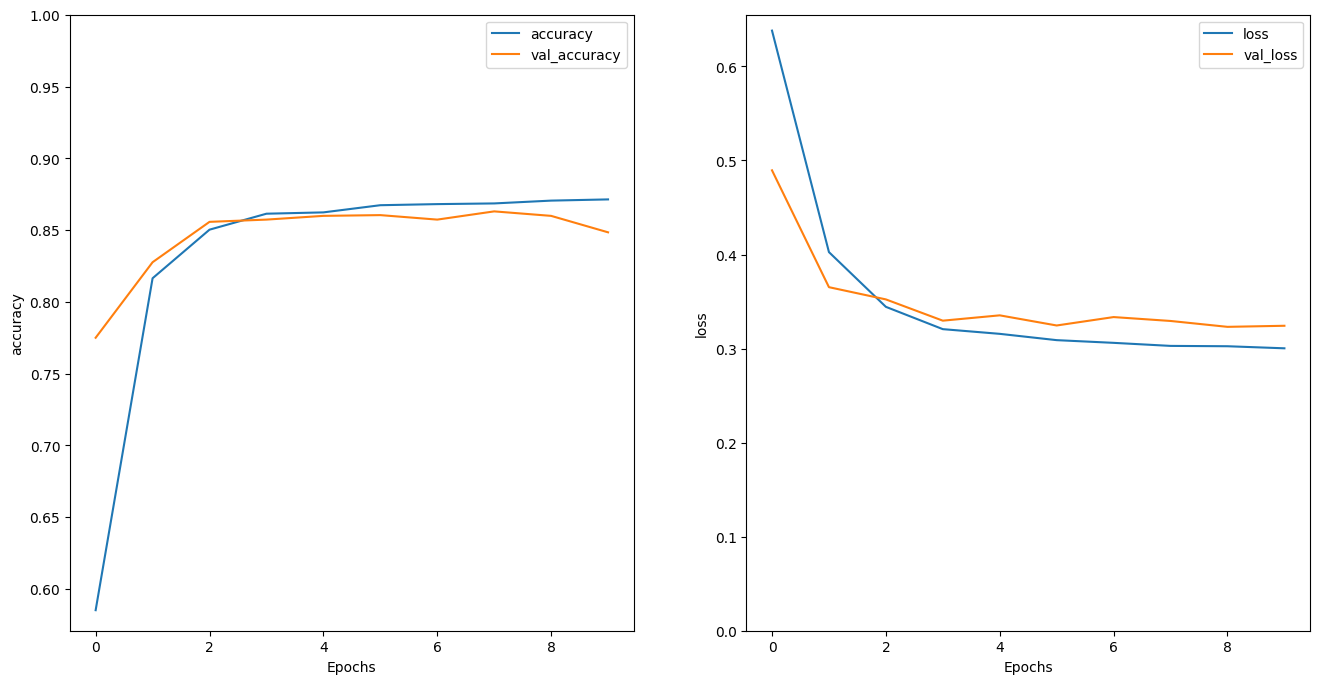

In [17]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Jalankan prediksi pada kalimat baru:

Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif.

In [18]:
sample_text = ('The movie was cool. The animation and the graphics '
              'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


# **Stack Two or More LSTM Layers**

Lapisan berulang Keras memiliki dua mode yang tersedia yang dikontrol oleh argumen konstruktor return_sequences :

- Jika False, ia hanya mengembalikan keluaran terakhir untuk setiap urutan masukan (bentuk tensor 2D (batch_size, output_features)). Ini adalah default yang digunakan pada model sebelumnya.

- Jika True, Sequence lengkap output berturut-turut untuk setiap langkah waktu dikembalikan (bentuk tensor 3D (ukuran_batch, langkah waktu, fitur_output)).

Berikut adalah alur informasi dengan return_sequences=True:

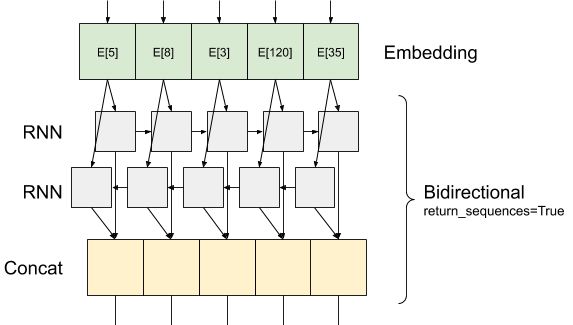

Hal yang menarik dari penggunaan RNN dengan return_sequences=True adalah outputnya masih memiliki 3 axis, sama seperti inputnya, sehingga bisa diteruskan ke layer RNN lain, seperti ini:

In [19]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [21]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 81s 156ms/step - loss: 0.6288 - accuracy: 0.5929 - val_loss: 0.4580 - val_accuracy: 0.7849
Epoch 2/10
391/391 [==============================] - 48s 122ms/step - loss: 0.3983 - accuracy: 0.8291 - val_loss: 0.3582 - val_accuracy: 0.8417
Epoch 3/10
391/391 [==============================] - 49s 125ms/step - loss: 0.3455 - accuracy: 0.8549 - val_loss: 0.3299 - val_accuracy: 0.8542
Epoch 4/10
391/391 [==============================] - 47s 121ms/step - loss: 0.3209 - accuracy: 0.8618 - val_loss: 0.3365 - val_accuracy: 0.8464
Epoch 5/10
391/391 [==============================] - 48s 122ms/step - loss: 0.3179 - accuracy: 0.8667 - val_loss: 0.3254 - val_accuracy: 0.8547
Epoch 6/10
391/391 [==============================] - 48s 121ms/step - loss: 0.3096 - accuracy: 0.8673 - val_loss: 0.3307 - val_accuracy: 0.8651
Epoch 7/10
391/391 [==============================] - 47s 121ms/step - loss: 0.3077 - accuracy: 0.8707 - val_loss: 0.3281 - val_ac

In [22]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 20s 51ms/step - loss: 0.3247 - accuracy: 0.8632
Test Loss: 0.32465457916259766
Test Accuracy: 0.8631600141525269


In [23]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
                'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[-2.0619116]]


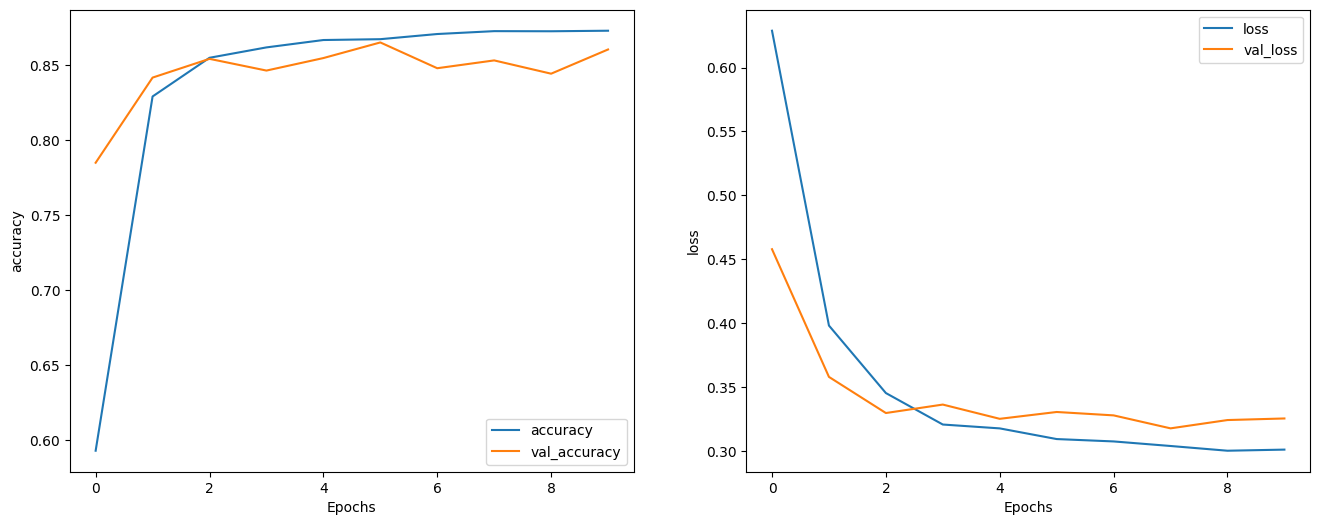

In [24]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# **Catatan**

Informasi menarik lain terkait dengan GRU layers (https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

Informasi membuat custom RNN --> Keras RNN Guide (https://www.tensorflow.org/guide/keras/rnn).